In [1]:
%%capture
!pip install torch==2.0.1

In [ ]:
%%capture
!pip install pymatgen==2022.11.7
!pip install Matminer==0.9.0
!pip install tqdm==4.64.1
!pip install p_tqdm==1.4.0
!pip install hydra-core==1.1.0
!pip install smact==2.2.1
!pip install torch_scatter==2.1.1
!pip install torch_geometric==1.7.2
!pip install torch_sparse==0.6.17
!pip install pytorch-lightning==2.0.8
!pip install python-dotenv==1.0.0
!pip install torchvision==0.15.2
!pip install torchaudio==2.0.2
!pip install PyYAML==6.0
!pip install ruamel.yaml==0.17.21
!pip install ruamel.yaml.clib==0.2.7

clone the cdvae code and copy the post processing metrics into the current directory

In [ ]:
!git clone https://github.com/txie-93/cdvae
%cd cdvae

/content/cdvae


In [ ]:
!pip install -e .

Obtaining file:///content/cdvae
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cdvae
    Found existing installation: cdvae 0.0.1
    Uninstalling cdvae-0.0.1:
      Successfully uninstalled cdvae-0.0.1
  Running setup.py develop for cdvae


In [ ]:
# !cp ./scripts/eval_utils.py .
# !cp ./scripts/evaluate.py .
# !cp ./scripts/compute_metrics.py .

MAKE SURE TO RESTART RUNTIME (KERNEL)

In [ ]:
import pymatgen

In [ ]:
import os
import sys
import torch
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from pymatgen.io.cif import CifParser, CifFile
import numpy as np
import pandas as pd

In [ ]:
sys.path.append('/content/cdvae')
# sys.path.append('/content/cdvae/scripts')
# os.getcwd()

In [ ]:
os.environ["PROJECT_ROOT"] = '/content/cdvae'

In [ ]:
import cdvae

In [ ]:
%cd scripts
from compute_metrics import get_crystal_array_list
from compute_metrics import Crystal

/content/cdvae/scripts


Update this to wherever you put your eval_gen.pt file

In [ ]:
# Bandgap data
#d_gen = 'models/bandgap/eval_gen.pt'
#d_recon = 'models/bandgap/eval_recon.pt'
#d_opt = 'models/bandgap/eval_opt.pt'

# Bulk modulus data
#d_gen = 'models/bulkmodulus/eval_gen.pt'

# Dielectric data
d_gen = 'eval_gen.pt'

In [ ]:
# HERE choose which data set to load in

crys_array_list, _ = get_crystal_array_list(d_gen)
gen_crys = lambda x: Crystal(x)


In [ ]:
len(crys_array_list)

10000

In [ ]:
crys_array_list[-1]

{'frac_coords': array([[0.48452568, 0.5043129 , 0.05728995],
        [0.6281959 , 0.03762285, 0.07233039],
        [0.24850306, 0.18489712, 0.8730616 ],
        [0.46220413, 0.652811  , 0.57708573],
        [0.03597521, 0.7170002 , 0.16506177],
        [0.15007342, 0.25357798, 0.24143997],
        [0.35163334, 0.11060012, 0.4990901 ],
        [0.0152708 , 0.8678366 , 0.68163604],
        [0.87051105, 0.32436678, 0.67290515]], dtype=float32),
 'atom_types': array([51, 19, 47, 19, 19, 32, 32, 51, 19]),
 'lengths': array([6.6554785, 6.674423 , 6.408869 ], dtype=float32),
 'angles': array([ 93.07398,  92.01979, 108.21433], dtype=float32)}

In [ ]:
# This version of below code works on windows and in this version of the notebook should work on colab.
# This will take a long time to run! like ~1hr or so, try to make sure colab doesn't time out during this or you'll have to start over.
gen_crystals = [gen_crys(crys_array) for crys_array in crys_array_list]

In [ ]:
# import time
# import timeout_decorator

# count = 0
# limit = 5
# gen_crystals = list()
# timeout = 15   # [seconds]

# @timeout_decorator.timeout(5)
# def get_crystal(crys_array):
#     return Crystal(crys_array)

# for crys_array in crys_array_list:
#     print(count)
#     #timeout_start = time.time()
#     #while time.time() < timeout_start + timeout:
#     try:
#         gen_crystal = get_crystal(crys_array)#gen_crys(crys_array)
#     except:
#         print('Timeout on crystal', count)
#         continue
#     gen_crystals.append(gen_crystal)
#     count += 1
# #gen_crystals = [gen_crys(crys_array) for crys_array in crys_array_list]
# print(len(gen_crystals))

ModuleNotFoundError: ignored

In [ ]:
print(len(gen_crystals))

10000


In [ ]:
# Save the structures to a file so we don't have to read them in again!
import joblib

df = pd.DataFrame({'Structure': [c.structure for c in gen_crystals]})

with open('structures_generated.pkl', 'wb') as f:
    joblib.dump(df, f)

In [ ]:
import joblib
with open('structures_generated.pkl', 'rb') as f:
    df = joblib.load(f)

In [ ]:
gen_crystals = df["Structure"].tolist()

In [ ]:
def sort_counter(temp_counter):
    element_tuples = list(zip(list(temp_counter.keys()),list(temp_counter.values())))
    element_df = pd.DataFrame(element_tuples,columns=["Element[#]","Count"])
    element_df_sorted = element_df.sort_values(by=["Count"],ascending=False)
    return element_df_sorted

gen_atom_types = [np.array(one_crystal.atomic_numbers, dtype="int64") for one_crystal in gen_crystals]
gen_atom_types = np.concatenate(gen_atom_types, axis=0)
gen_atom_types_counter = Counter(gen_atom_types)
gen_atom_types_sorted = sort_counter(gen_atom_types_counter)

print(gen_atom_types_sorted[0:14])

    Element[#]  Count
4            8  22809
0            9  10421
28          16   5618
5           17   5524
15          34   4702
1           19   3863
13          11   3242
22           7   3184
18          37   2729
2           55   2606
6            3   2384
34          35   2238
39          15   2059
43          56   1886


Text(0.5, 1.0, 'Generated Structures')

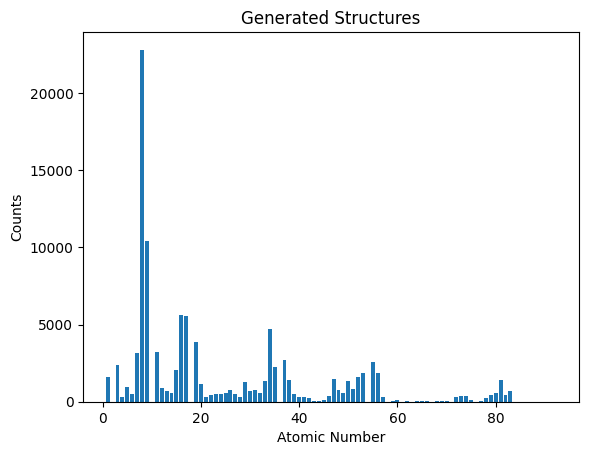

In [ ]:
fig1,ax1 = plt.subplots()
ax1.bar(gen_atom_types_sorted["Element[#]"],gen_atom_types_sorted["Count"])
ax1.set_xlabel('Atomic Number')
ax1.set_ylabel('Counts')
ax1.set_title('Generated Structures')

In [ ]:
# trainng data
from pymatgen.io.cif import CifParser, CifFile

try:
    #train_data = pd.read_csv('cdvae/data/bandgap/train.csv')
    #train_data = pd.read_csv('cdvae/data/bulkmodulus/train.csv')
    train_data = pd.read_csv('cdvae/data/dielectric/train.csv')
except:
    #train_data = pd.read_csv('data/bandgap/train.csv')
    #train_data = pd.read_csv('data/bulkmodulus/train.csv')
    train_data = pd.read_csv('data/dielectric/train.csv')
train_structures = [CifParser.from_string(i).get_structures()[0] for i in train_data["cif"]]
train_atom_types = [struct.atomic_numbers for struct in train_structures]
train_atom_types = np.concatenate(train_atom_types, axis=0)
train_atom_types_counter = Counter(train_atom_types)
train_atom_types_sorted = sort_counter(train_atom_types_counter)

print(train_atom_types_sorted[0:9])

/var/folders/5t/m2w79ns54wgb8x7bdj18ljwr0000gn/T/ipykernel_60143/2365852605.py:12: DeprecationWarning: `from_string` is deprecated!
Use from_str instead
  train_structures = [CifParser.from_string(i).get_structures()[0] for i in train_data["cif"]]
/Users/ryanjacobs/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/pymatgen/io/cif.py:1145: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


    Element[#]  Count
13           8   9883
15           9   3883
10          16   2780
18          34   1689
3           17   1559
11           3   1413
1            1   1387
2            7   1259
31          19   1112


In [ ]:
train_data

,Unnamed: 0,material_id,cif,log(poly_total),target
0,2622,mp-24375,# generated using pymatgen\ndata_TlH4NCl4\n_sy...,0.770802,-0.770802
1,4056,mp-1228809,# generated using pymatgen\ndata_AlReSi\n_symm...,1.591532,-1.591532
2,603,mp-1221557,# generated using pymatgen\ndata_MnZn(CrS2)4\n...,1.129183,-1.129183
3,706,mp-752745,# generated using pymatgen\ndata_Li4MnCr(WO6)2...,1.889124,-1.889124
4,3783,mp-753539,# generated using pymatgen\ndata_SbOF\n_symmet...,0.874998,-0.874998
...,...,...,...,...,...
4082,563,mp-29946,# generated using pymatgen\ndata_IO2F\n_symmet...,1.024949,-1.024949
4083,1405,mp-675511,# generated using pymatgen\ndata_Sm2PbS4\n_sym...,1.613778,-1.613778
4084,39,mp-32684,# generated using pymatgen\ndata_HBr\n_symmetr...,1.165171,-1.165171
4085,1573,mp-19086,# generated using pymatgen\ndata_BaCoO2\n_symm...,1.198474,-1.198474


In [ ]:
lst = [struct.atomic_numbers for struct in train_structures]
lst

[(23, 32, 44, 44),
 (13, 13, 13, 13, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35),
 (24, 24, 24, 24, 26, 26, 26, 26, 15, 15, 15, 15),
 (37, 37, 1, 1, 1, 1, 1, 1, 78),
 (21, 21, 76, 46),
 (19, 19, 29, 29, 52, 52),
 (50, 50, 50, 50, 16, 16, 16, 16),
 (26, 26, 26, 78),
 (25, 28, 28, 51),
 (21, 21, 7, 17, 17),
 (55, 55, 11, 11, 11, 11, 5, 5, 8, 8, 8, 8, 8, 8),
 (13, 13, 81, 81, 9, 9, 9, 9, 9, 9, 9, 9),
 (13, 13, 44, 78),
 (40, 40, 40, 13, 13, 13, 28, 28, 28),
 (51, 51, 51, 51, 78, 78, 78, 78, 78, 78),
 (19, 19, 25, 25, 9, 9, 9, 9, 9, 9),
 (12, 50, 45, 45),
 (37, 37, 37, 37, 37, 37, 37, 79, 79, 79, 79, 79, 8, 8),
 (72, 72, 32, 32, 52, 52, 52, 52, 52, 52, 52, 52),
 (15, 15, 15, 15, 74, 74),
 (38, 14, 14, 46, 46),
 (3, 12, 12, 45),
 (51, 51, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17),
 (3, 3, 3, 3, 26, 26, 26, 26, 8, 8, 8, 8, 8, 8, 8, 8),
 (40, 78, 78, 78),
 (41, 41, 41, 41, 41, 41, 76, 76),
 (22, 31, 45, 45),
 (55, 55, 28, 28, 17, 17, 17, 17, 17, 17),
 (47, 83, 52, 52),
 (13, 13, 13, 15, 15,

Text(0.5, 1.0, 'Training Structures')

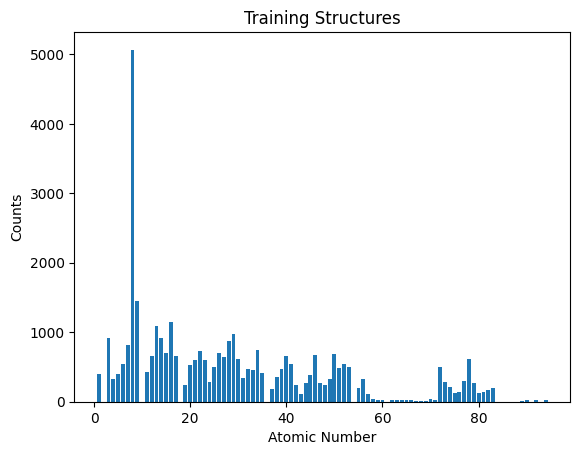

In [ ]:
fig2,ax2 = plt.subplots()
ax2.bar(train_atom_types_sorted["Element[#]"],train_atom_types_sorted["Count"])
ax2.set_xlabel('Atomic Number')
ax2.set_ylabel('Counts')
ax2.set_title('Training Structures')

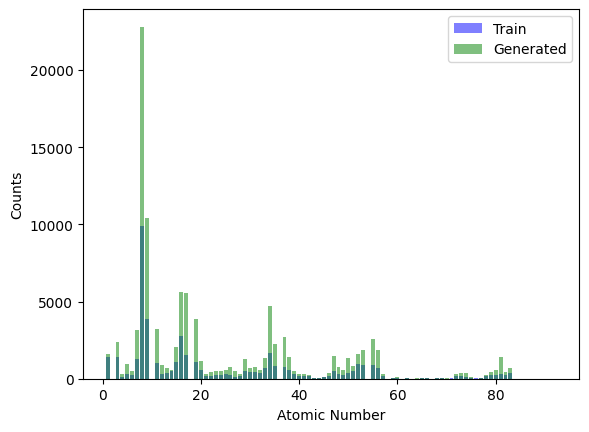

In [ ]:
plt.clf()
plt.bar(train_atom_types_sorted["Element[#]"], train_atom_types_sorted["Count"], label='Train', color='blue', alpha=0.5)
plt.bar(gen_atom_types_sorted["Element[#]"], gen_atom_types_sorted["Count"], label='Generated', color='green', alpha=0.5)
plt.xlabel('Atomic Number')
plt.ylabel('Counts')
plt.legend(loc='best')

plt.savefig('structure_barchart_gen_v2.png', dpi=250, bbox_inches='tight')

In [ ]:
# Examine the elemental distribution of training data and generated data
from pymatgen.core import Composition, Element

generated_element_dict = dict()
generated_element_dict_Z = dict()
for s in df['Structure']:
    c = Composition(s.formula).as_dict()
    for k in c.keys():
        if k not in generated_element_dict:
            generated_element_dict[k] = 1
            generated_element_dict_Z[Element(k).Z] = 1
        else:
            generated_element_dict[k] += 1
            generated_element_dict_Z[Element(k).Z] += 1


In [ ]:
# Examine the elemental distribution of training data and generated data
from pymatgen.core import Composition, Element, Structure

generated_element_dict_train = dict()
generated_element_dict_Z_train = dict()
for cif in train_data['cif']:
    s = Structure.from_str(cif, fmt='cif')
    c = Composition(s.formula).as_dict()
    for k in c.keys():
        if k not in generated_element_dict_train:
            generated_element_dict_train[k] = 1
            generated_element_dict_Z_train[Element(k).Z] = 1
        else:
            generated_element_dict_train[k] += 1
            generated_element_dict_Z_train[Element(k).Z] += 1


/Users/ryanjacobs/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/pymatgen/io/cif.py:1145: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


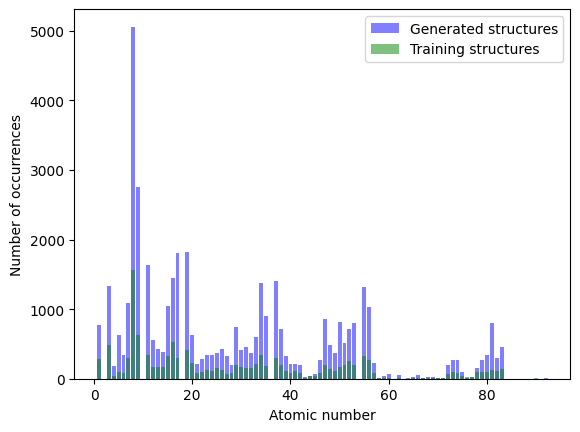

In [ ]:
xvals = generated_element_dict_Z.keys()
yvals = generated_element_dict_Z.values()

xvals_train = generated_element_dict_Z_train.keys()
yvals_train = generated_element_dict_Z_train.values()

plt.clf()
plt.bar(xvals, yvals, color='blue', alpha=0.5, label = 'Generated structures')
plt.bar(xvals_train, yvals_train, color='green', alpha=0.5, label = 'Training structures')
plt.xlabel('Atomic number')
plt.ylabel('Number of occurrences')
plt.legend(loc='upper right')

plt.savefig('Histogram_materials_elements.png', dpi=250, bbox_inches='tight')

In [ ]:
from pymatgen.core import Composition
count = 0
for s in train_structures:
    comp = Composition(s.formula)
    if 'O' in comp:
        print(comp.as_dict())
        count += 1
print(count)

defaultdict(<class 'float'>, {'Cs': 2.0, 'Na': 4.0, 'B': 2.0, 'O': 6.0})
defaultdict(<class 'float'>, {'Rb': 7.0, 'Au': 5.0, 'O': 2.0})
defaultdict(<class 'float'>, {'Li': 4.0, 'Fe': 4.0, 'O': 8.0})
defaultdict(<class 'float'>, {'Al': 3.0, 'P': 3.0, 'O': 12.0})
defaultdict(<class 'float'>, {'Cd': 2.0, 'In': 4.0, 'O': 8.0})
defaultdict(<class 'float'>, {'Ni': 2.0, 'Bi': 2.0, 'O': 6.0})
defaultdict(<class 'float'>, {'Zn': 2.0, 'As': 2.0, 'O': 7.0})
defaultdict(<class 'float'>, {'Co': 3.0, 'Te': 1.0, 'O': 8.0})
defaultdict(<class 'float'>, {'Cs': 2.0, 'Ni': 1.0, 'O': 2.0})
defaultdict(<class 'float'>, {'Sc': 2.0, 'V': 2.0, 'O': 8.0})
defaultdict(<class 'float'>, {'Zn': 2.0, 'C': 2.0, 'O': 6.0})
defaultdict(<class 'float'>, {'Ge': 4.0, 'O': 8.0})
defaultdict(<class 'float'>, {'V': 2.0, 'Cd': 2.0, 'O': 7.0})
defaultdict(<class 'float'>, {'Cs': 2.0, 'Al': 2.0, 'O': 4.0})
defaultdict(<class 'float'>, {'Ag': 4.0, 'S': 2.0, 'O': 8.0})
defaultdict(<class 'float'>, {'Cs': 2.0, 'Sc': 2.0, 'O': 4.0

In [ ]:
import os
os.getcwd()

'/Users/ryanjacobs/Documents/Research Projects/NSF_CSSI/cdvae_work'

In [ ]:
# Use the bandgap model to predict the HSE bandgaps of the new generated structures
import numpy as np
import pandas as pd
from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GraphBatchDistanceConvert, GaussianDistance
from megnet.models import MEGNetModel

def run_bandgap(input_dict):
    fidelity_dict = {'pbe': 0,
                     'pbe1': 1,
                     'mbj': 2,
                     'gllb-sc': 3,
                     'hse': 4,
                     'gw': 5,
                     'exp': 6}

    TRAIN_FIDELITIES = ['pbe','pbe1','mbj', 'gllb-sc', 'hse', 'gw','exp']

    crystal_graph = CrystalGraph(bond_converter=GaussianDistance(centers=np.linspace(0, 6, 100), width=0.5), cutoff=5.0)

    model = MEGNetModel(nfeat_edge=100, nfeat_global=None, ngvocal=len(TRAIN_FIDELITIES),
                        global_embedding_dim=16,  nblocks=3, nvocal=95,
                        npass=2, graph_converter=crystal_graph, lr=1e-3)
# these files are in the "files from ryan" subfolders
    try:
        model.load_weights('val_mae_00206_0.193622.hdf5')
    except:
        model.load_weights('cdvae/val_mae_00206_0.193622.hdf5')

    # Convert the input pymatgen structure to the crystal graph object
    fidelity_list = input_dict['fidelity_list'] # PBE
    structure_list = input_dict['structure_list']

    graphs_list = list()
    comps_list = list()
    fidelity_list_new = list()
    structure_list_new = list()
    count = 0
    for s, f in zip(structure_list, fidelity_list):
        try:
            graph = crystal_graph.convert(s)
            graphs_list.append(graph)
            fidelity_list_new.append(f)
            comps_list.append(s.formula)
            structure_list_new.append(s)
        except:
            print('Issue with structure', s)
            #del structure_list[count]
        count += 1

    for fidelity, graph in zip(fidelity_list, graphs_list):
        graph['state'] = [fidelity_dict[fidelity]]

    preds = model.predict_graphs(graphs_list)
    preds_round = [round(p[0], 3) for p in preds]

    print(len(structure_list_new), len(comps_list), len(fidelity_list_new), len(preds_round))

    preds_df = pd.DataFrame({'Structure': structure_list_new,
                             'Formula': comps_list,
                             'Fidelity level': fidelity_list_new,
                             'Predicted bandgap (eV)': preds_round})

    return preds_df


In [ ]:
# Use the bandgap model to predict the HSE bandgaps of the new generated structures
import numpy as np
import pandas as pd
from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GraphBatchDistanceConvert, GaussianDistance
from megnet.models import MEGNetModel

def run_bulkmodulus(input_dict):

    crystal_graph = CrystalGraph(bond_converter=GaussianDistance(centers=np.linspace(0, 6, 100), width=0.5), cutoff=10.0)

    model = MEGNetModel(nfeat_edge=100, nfeat_global=None,
                        nblocks=3, nvocal=95,
                        npass=2, graph_converter=crystal_graph, lr=1e-3)

    try:
        model.load_weights('analysis/bulkmodulus/val_mae_00659_0.050791.hdf5')
    except:
        model.load_weights('cdvae/analysis/bulkmodulus/val_mae_00659_0.050791.hdf5')

    # Convert the input pymatgen structure to the crystal graph object
    #fidelity_list = input_dict['fidelity_list'] # PBE
    structure_list = input_dict['structure_list']

    graphs_list = list()
    comps_list = list()
    #fidelity_list_new = list()
    structure_list_new = list()
    count = 0
    for s in structure_list:
        try:
            graph = crystal_graph.convert(s)
            graphs_list.append(graph)
            #fidelity_list_new.append(f)
            comps_list.append(s.formula)
            structure_list_new.append(s)
        except:
            print('Issue with structure', s)
            #del structure_list[count]
        count += 1

    #for fidelity, graph in zip(fidelity_list, graphs_list):
    #    graph['state'] = [fidelity_dict[fidelity]]

    preds = model.predict_graphs(graphs_list)
    preds_round = [round(p[0], 3) for p in preds]

    print(len(structure_list_new), len(comps_list),len(preds_round))

    preds_df = pd.DataFrame({'Structure': structure_list_new,
                             'Formula': comps_list,
                             'Predicted log10 Bulk Modulus (GPa)': preds_round})

    return preds_df


In [ ]:
# Use the bandgap model to predict the HSE bandgaps of the new generated structures
import numpy as np
import pandas as pd
from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GraphBatchDistanceConvert, GaussianDistance
from megnet.models import MEGNetModel

def run_dielectric(input_dict):

    crystal_graph = CrystalGraph(bond_converter=GaussianDistance(centers=np.linspace(0, 6, 100), width=0.5), cutoff=10.0)

    model = MEGNetModel(nfeat_edge=100, nfeat_global=None,
                        nblocks=3, nvocal=95,
                        npass=2, graph_converter=crystal_graph, lr=1e-3)

    try:
        model.load_weights('analysis/dielectric/val_mae_00350_0.148586.hdf5')
    except:
        model.load_weights('cdvae/analysis/dielectric/val_mae_00350_0.148586.hdf5')

    # Convert the input pymatgen structure to the crystal graph object
    #fidelity_list = input_dict['fidelity_list'] # PBE
    structure_list = input_dict['structure_list']

    graphs_list = list()
    comps_list = list()
    #fidelity_list_new = list()
    structure_list_new = list()
    count = 0
    for s in structure_list:
        try:
            graph = crystal_graph.convert(s)
            graphs_list.append(graph)
            #fidelity_list_new.append(f)
            comps_list.append(s.formula)
            structure_list_new.append(s)
        except:
            print('Issue with structure', s)
            #del structure_list[count]
        count += 1

    #for fidelity, graph in zip(fidelity_list, graphs_list):
    #    graph['state'] = [fidelity_dict[fidelity]]

    preds = model.predict_graphs(graphs_list)
    preds_round = [round(p[0], 3) for p in preds]

    print(len(structure_list_new), len(comps_list),len(preds_round))

    preds_df = pd.DataFrame({'Structure': structure_list_new,
                             'Formula': comps_list,
                             'Predicted log10 dielectric constant': preds_round})

    return preds_df


In [ ]:
gen_crystals = df['Structure']

In [ ]:
import os

os.getcwd()

'/Users/ryanjacobs/Documents/Research Projects/NSF_CSSI/cdvae_work/cdvae'

In [ ]:
os.path.exists(os.path.join(os.getcwd(),'analysis/dielectric/val_mae_00350_0.148586.hdf5'))

True

In [ ]:
input_dict = dict()
#input_dict['fidelity_list'] = ['hse' for i in gen_crystals] # 4 = HSE
#input_dict['structure_list'] = [c.structure for c in gen_crystals]
input_dict['structure_list'] = gen_crystals

#preds_df = run_bandgap(input_dict)
#preds_df = run_bulkmodulus(input_dict)
preds_df = run_dielectric(input_dict)

10000 10000 10000


In [ ]:
preds_df

,Structure,Formula,Predicted log10 dielectric constant
0,"[[4.46248297 5.52182143 5.51148712] F, [4.4925...",Cs2 K1 Ta1 O1 F5,1.100
1,"[[ 5.52529051 3.27853998 -1.08129941] Cl, [ 5...",Li1 Tl1 Cl3,1.017
2,"[[1.04250192 0.25986361 3.65516959] I, [3.1577...",Hg1 I2,1.020
3,"[[4.12541731 1.04048094 3.42353887] Li, [1.614...",Li1 Al1 Ga1 H3 O5 F1,0.939
4,"[[1.0026545 0.43889151 3.92474619] Na, [1.160...",Cs2 Na1 Li1 Cu2 As1 Se1 O9 F1,0.905
...,...,...,...
9995,"[[1.19430094 1.00913486 0.93458543] Bi, [3.358...",Na1 Bi3 I2 Br2 O2,1.325
9996,"[[1.67650226 4.5215103 6.05687714] Br, [2.750...",Rb1 Ba2 Br2 Cl1,1.154
9997,"[[3.51767085 0.43447247 7.46783337] Sr, [1.690...",Sr1 Cr1 Ag1 H2 Pb1 Cl2 O3 F1,1.138
9998,"[[ 4.7008949 1.14030355 11.22409569] Cs, [2....",Cs5 Rb1 Ti2 Al2 As8 Br1 O1,1.283


In [ ]:
# Bandgap promising
# Look for materials that are in the range of 1.1-1.7 eV

df_promising = preds_df[preds_df['Predicted bandgap (eV)'] <= 1.7]
df_promising = df_promising[df_promising['Predicted bandgap (eV)'] >= 1.1]
df_promising.shape

In [ ]:
# Bulkmodulus promising
# Look for materials that are greater than 2.3 on log scale (just to get tractable number)

df_promising = preds_df[preds_df['Predicted log10 Bulk Modulus (GPa)'] > 2.3]
df_promising.shape

(387, 3)

In [ ]:
# Dielectric promising
# Look for materials that are greater than 2.3 on log scale (just to get tractable number)

df_promising = preds_df[preds_df['Predicted log10 dielectric constant'] > 1.8]
df_promising.shape

(136, 3)

In [ ]:
df_promising.to_csv('promising_materials_generated.csv', index=False)

with open('promising_materials_generated.pkl', 'wb') as f:
    joblib.dump(df_promising, f)

In [ ]:
from pymatgen.io.vasp import Poscar

for s in df_promising['Structure']:
    formula = s.formula
    p = Poscar(s)
    p.write_file(filename='POSCAR_'+formula)

In [ ]:
import os
os.getcwd()

'/Users/ryanjacobs/Documents/Research Projects/NSF_CSSI/cdvae_work'

In [ ]:
import joblib
with open('cdvae/promising_materials_generated.pkl', 'rb') as f:
    df_promising = joblib.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'cdvae/promising_materials_generated.pkl'

In [ ]:
df_promising

,Structure,Formula,Predicted log10 dielectric constant
18,"[[0.77773126 1.84029267 1.67497552] La, [3.428...",La1 O2,2.088
79,"[[3.45638326 4.20820798 0.48708395] Ag, [0.727...",Ag2 Bi2 Se1 Br1 Cl2 O2,2.115
97,"[[0.63880931 3.24489087 1.06094759] Pb, [ 2.95...",Li1 Pb3 Se4,2.406
275,"[[3.23948153 2.81145642 6.27129739] Fe, [3.488...",Fe1 N1 O3,1.910
296,"[[3.06670415 2.81275301 0.63372987] Te, [1.342...",Y1 Te1,2.660
...,...,...,...
9699,"[[1.13026047 3.21493818 0.25248287] Na, [0.247...",Na5 Ta1 Nb1 Se7,2.880
9799,"[[1.39760027 3.68195325 0.45974526] Ta, [1.307...",Ta2 Fe3 Si2,1.827
9881,"[[0.3138598 2.38049339 6.71556753] Y, [3.1885...",Sr1 Y2 Sn1 Te4 Pb6 Se6,1.871
9957,"[[1.8459298 2.23499113 8.39129787] Nb, [4.001...",Na4 Nb2 O10,2.079


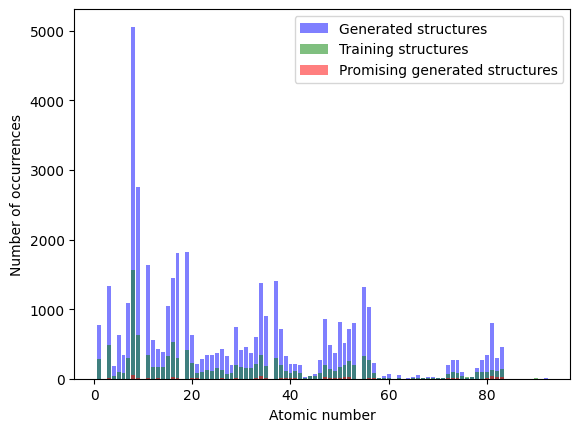

In [ ]:
# For bulk modulus, examine the element distribution of the promising systems, compare to full distribution

# Examine the elemental distribution of training data and generated data
from pymatgen.core import Composition, Element, Structure

generated_element_dict_promising = dict()
generated_element_dict_Z_promising = dict()
for s in df_promising['Structure']:
    #s = Structure.from_str(cif, fmt='cif')
    c = Composition(s.formula).as_dict()
    for k in c.keys():
        if k not in generated_element_dict_promising:
            generated_element_dict_promising[k] = 1
            generated_element_dict_Z_promising[Element(k).Z] = 1
        else:
            generated_element_dict_promising[k] += 1
            generated_element_dict_Z_promising[Element(k).Z] += 1


xvals = generated_element_dict_Z.keys()
yvals = generated_element_dict_Z.values()

xvals_train = generated_element_dict_Z_train.keys()
yvals_train = generated_element_dict_Z_train.values()

xvals_promising = generated_element_dict_Z_promising.keys()
yvals_promising = generated_element_dict_Z_promising.values()

plt.clf()
plt.bar(xvals, yvals, color='blue', alpha=0.5, label = 'Generated structures')
plt.bar(xvals_train, yvals_train, color='green', alpha=0.5, label = 'Training structures')
plt.bar(xvals_promising, yvals_promising, color='red', alpha=0.5, label = 'Promising generated structures')
plt.xlabel('Atomic number')
plt.ylabel('Number of occurrences')
plt.legend(loc='upper right')

plt.savefig('Histogram_materials_elements_promisingsubset.png', dpi=250, bbox_inches='tight')

In [ ]:
# Bulk modulus
# Lots of B, C, N, refractories like Ta, Ir, Nb, Mo. Seems to make sense
generated_element_dict_promising

{'Ta': 49,
 'Ti': 46,
 'Fe': 28,
 'Si': 70,
 'C': 66,
 'Li': 6,
 'V': 58,
 'Ir': 104,
 'Al': 54,
 'Co': 34,
 'Pt': 28,
 'N': 49,
 'Nb': 71,
 'Mo': 71,
 'As': 6,
 'Hf': 19,
 'Ni': 46,
 'B': 90,
 'Rh': 35,
 'Ru': 48,
 'Sn': 10,
 'Os': 12,
 'Pd': 17,
 'Ge': 28,
 'Ce': 2,
 'W': 36,
 'Be': 27,
 'O': 11,
 'Zn': 20,
 'Ga': 12,
 'Sc': 6,
 'Cu': 10,
 'P': 33,
 'Tc': 17,
 'Zr': 16,
 'Re': 23,
 'Mn': 21,
 'Cr': 21,
 'Cd': 5,
 'Sb': 7,
 'Au': 13,
 'Mg': 4,
 'Y': 3,
 'Ag': 2,
 'H': 2,
 'Er': 1,
 'Th': 2,
 'Tl': 1,
 'Ca': 3,
 'S': 1,
 'Te': 2,
 'Hg': 1}

In [ ]:
# Dielectric
# Lots of BO, late metals like Ag, Bi, Se, Tl, Te, Sb. Not sure if makes sense, I don't have much intuition about this.
generated_element_dict_promising

{'La': 4,
 'O': 48,
 'Ag': 22,
 'Bi': 25,
 'Se': 36,
 'Br': 8,
 'Cl': 9,
 'Li': 10,
 'Pb': 19,
 'Fe': 9,
 'N': 3,
 'Y': 6,
 'Te': 23,
 'Na': 17,
 'V': 3,
 'S': 23,
 'Tl': 33,
 'Pd': 3,
 'Ba': 10,
 'Cd': 6,
 'Sn': 16,
 'Sc': 6,
 'Ta': 9,
 'F': 12,
 'Sr': 13,
 'Cu': 7,
 'Sb': 27,
 'As': 13,
 'Rb': 3,
 'I': 3,
 'Tc': 1,
 'Mo': 1,
 'Hf': 9,
 'Zn': 2,
 'Mg': 3,
 'Ru': 2,
 'Ca': 7,
 'In': 6,
 'Ga': 3,
 'Nb': 8,
 'W': 4,
 'Dy': 3,
 'Ni': 3,
 'Al': 4,
 'Cr': 2,
 'Zr': 4,
 'Cs': 2,
 'Hg': 4,
 'B': 2,
 'K': 3,
 'Rh': 1,
 'P': 1,
 'Yb': 1,
 'Si': 3,
 'Ti': 3,
 'Pr': 1,
 'Tb': 1,
 'Co': 1,
 'U': 1}

In [ ]:
relaxed_energies = list()
relaxed_structures = list()

In [ ]:
import warnings
import numpy as np

from m3gnet.models import Relaxer
from pymatgen.core import Lattice, Structure

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

# Init a Mo structure with stretched lattice (DFT lattice constant ~ 3.168)
#mo = Structure(Lattice.cubic(3.3), ["Mo", "Mo"], [[0., 0., 0.], [0.5, 0.5, 0.5]])

relaxer = Relaxer()  # This loads the default pre-trained model

#relax_results = relaxer.relax(mo, verbose=True)

#relaxed_structures = list()
#relaxed_energies = list()
#count = 0
try:
    count = len(relaxed_energies) # resuming from previous run
except:
    count = 0
    relaxed_structures = list()
    relaxed_energies = list()
for i, s in enumerate(df_promising['Structure']):
    print(i)
    if i >= count:
        print('HERE', count)
        try:
            relax_results = relaxer.relax(s, verbose=False)
            final_structure = relax_results['final_structure']
            final_energy_per_atom = float(relax_results['trajectory'].energies[-1] / len(s))
            print(f"Relaxed lattice parameter is {final_structure.lattice.abc[0]:.3f} Å")
            print(f"Final energy is {final_energy_per_atom:.3f} eV/atom")
            relaxed_energies.append(final_energy_per_atom)
            relaxed_structures.append(final_structure)
            count += 1
        except:
            print('Found an issue with structure', count, s)
            relaxed_energies.append(np.nan)
            relaxed_structures.append(np.nan)
            count += 1

0
HERE 0


Relaxed lattice parameter is 4.055 Å
Final energy is -7.632 eV/atom
1
HERE 1


Relaxed lattice parameter is 6.339 Å
Final energy is -3.910 eV/atom
2
HERE 2
Relaxed lattice parameter is 7.398 Å
Final energy is -4.016 eV/atom
3
HERE 3
Relaxed lattice parameter is 6.359 Å
Final energy is -6.486 eV/atom
4
HERE 4
Relaxed lattice parameter is 3.799 Å
Final energy is -5.986 eV/atom
5
HERE 5
Relaxed lattice parameter is 3.609 Å
Final energy is -5.684 eV/atom
6
HERE 6
Relaxed lattice parameter is 7.214 Å
Final energy is -4.126 eV/atom
7
HERE 7
Relaxed lattice parameter is 6.580 Å
Final energy is -3.590 eV/atom
8
HERE 8
Relaxed lattice parameter is 5.778 Å
Final energy is -7.137 eV/atom
9
HERE 9
Relaxed lattice parameter is 6.080 Å
Final energy is -8.773 eV/atom
10
HERE 10
Relaxed lattice parameter is 4.187 Å
Final energy is -4.983 eV/atom
11
HERE 11
Relaxed lattice parameter is 4.048 Å
Final energy is -3.788 eV/atom
12
HERE 12
Relaxed lattice parameter is 3.934 Å
Final energy is -4.437 eV/atom
13
HERE 13
Relaxed lattice parameter is 4.134 Å
Final energy is -8.594 eV/atom


Relaxed lattice parameter is 6.271 Å
Final energy is -3.831 eV/atom
106
HERE 106
Relaxed lattice parameter is 5.295 Å
Final energy is -3.516 eV/atom
107
HERE 107
Relaxed lattice parameter is 6.453 Å
Final energy is -3.551 eV/atom
108
HERE 108
Relaxed lattice parameter is 4.354 Å
Final energy is -6.130 eV/atom
109
HERE 109
Relaxed lattice parameter is 6.222 Å
Final energy is -4.666 eV/atom
110
HERE 110
Relaxed lattice parameter is 5.898 Å
Final energy is -4.024 eV/atom
111
HERE 111
Relaxed lattice parameter is 4.646 Å
Final energy is -5.569 eV/atom
112
HERE 112
Relaxed lattice parameter is 4.690 Å
Final energy is -5.538 eV/atom
113
HERE 113
Relaxed lattice parameter is 3.554 Å
Final energy is -3.270 eV/atom
114
HERE 114
Relaxed lattice parameter is 3.638 Å
Final energy is -7.879 eV/atom
115
HERE 115
Relaxed lattice parameter is 5.581 Å
Final energy is -6.991 eV/atom
116
HERE 116
Relaxed lattice parameter is 15.938 Å
Final energy is -2.998 eV/atom
117
HERE 117
Relaxed lattice parameter i

In [ ]:
print(len(relaxed_energies), len(relaxed_structures))

136 136


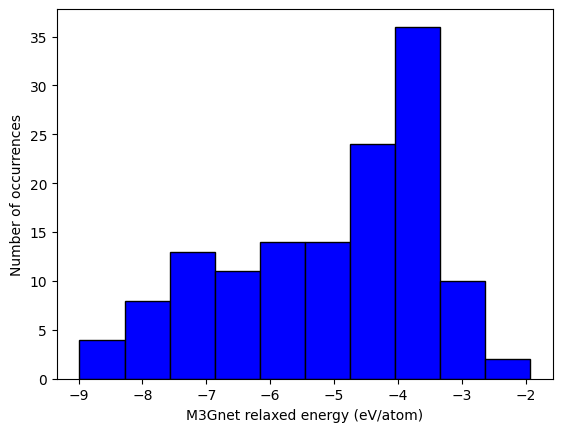

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.hist(relaxed_energies, color='blue', edgecolor='black')
plt.xlabel('M3Gnet relaxed energy (eV/atom)')
plt.ylabel('Number of occurrences')
plt.savefig('histogram_relaxed_energies.png', dpi=250, bbox_inches='tight')

In [ ]:
from pymatgen.io.vasp import Poscar

for s in relaxed_structures:
    try:
        formula = s.formula
        p = Poscar(s)
        p.write_file(filename='POSCAR_relaxed_'+formula)
    except:
        pass

In [ ]:
# Predict relaxed bandgaps

input_dict = dict()
input_dict['fidelity_list'] = ['hse' for i in relaxed_structures if type(i) != float] # 4 = HSE
input_dict['structure_list'] = [i for i in relaxed_structures if type(i) != float]

preds_df_relaxed = run_bandgap(input_dict)

669 669 669 669


In [ ]:
# Predict relaxed bulk modulus

input_dict = dict()
input_dict['structure_list'] = [i for i in relaxed_structures if type(i) != float]

preds_df_relaxed = run_bulkmodulus(input_dict)

/Users/ryanjacobs/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


387 387 387


In [ ]:
# Predict relaxed dielectric

input_dict = dict()
input_dict['structure_list'] = [i for i in relaxed_structures if type(i) != float]

preds_df_relaxed = run_dielectric(input_dict)

/Users/ryanjacobs/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


136 136 136


In [ ]:
preds_df_relaxed

,Structure,Formula,Predicted log10 dielectric constant
0,"[[0.92196635 1.77288451 1.63194585] La, [3.553...",La1 O2,1.292
1,"[[3.63591188 4.56481157 0.52082297] Ag, [0.736...",Ag2 Bi2 Se1 Br1 Cl2 O2,1.931
2,"[[1.64849516 3.17102404 1.06119852] Pb, [ 4.20...",Li1 Pb3 Se4,2.003
3,"[[7.78076607 4.17939903 3.35186264] Fe, [6.321...",Fe1 N1 O3,0.877
4,"[[3.24032768 2.96605179 0.50750197] Te, [1.386...",Y1 Te1,2.962
...,...,...,...
131,"[[0.89598795 3.10989623 0.14040965] Na, [0.167...",Na5 Ta1 Nb1 Se7,1.444
132,"[[ 0.93341628 3.7830832 -0.12214777] Ta, [0....",Ta2 Fe3 Si2,1.916
133,"[[-0.02807999 2.05797222 6.4441614 ] Y, [2.8...",Sr1 Y2 Sn1 Te4 Pb6 Se6,1.763
134,"[[1.26106424 2.404888 8.79182579] Nb, [3.425...",Na4 Nb2 O10,1.354


In [ ]:
# joblib had error with pickling weakref object, but dill seems to work

import dill

preds_df_relaxed.to_csv('promising_materials_generated_relaxed.csv', index=False)

with open('promising_materials_generated_relaxed.pkl', 'wb') as f:
    dill.dump(preds_df_relaxed, f)

In [ ]:
df_promising.sort_values('Formula')

,Structure,Formula,Predicted log10 dielectric constant
8331,"[[4.99069093 1.31937029 1.84338182] Pb, [2.375...",Ag1 As1 Pb2 I3,1.952
7405,"[[1.52086798 5.17358056 9.17312823] S, [3.7241...",Ag1 Bi3 S6,2.010
4210,"[[2.84767867 3.33154763 1.97214246] Ag, [0.855...",Ag1 Sb1 S2,2.422
4215,[[3.06718240e+00 6.22325408e-01 5.39478807e-04...,Ag2 Bi1 I1 O2,2.400
592,"[[2.65908486 1.69942034 3.44327776] Bi, [ 0.85...",Ag2 Bi1 S3,2.353
...,...,...,...
7781,"[[1.57022656 0.07819827 3.15608373] Y, [3.0715...",Y2 Te2,2.360
5348,"[[1.69270072 1.76263544 4.06319613] Hf, [4.009...",Yb1 Hf2 Si1,2.454
8305,"[[2.18275641 3.87259365 5.08180583] Zn, [0.851...",Zn3 Bi2 Te5,1.907
4146,"[[3.11506005 3.22944354 4.69689769] Sn, [1.423...",Zr1 Sn1,1.867


In [ ]:
preds_df_relaxed.sort_values('Formula')

,Structure,Formula,Predicted log10 dielectric constant
117,"[[5.29422324 0.98500685 1.28252579] Pb, [2.272...",Ag1 As1 Pb2 I3,1.704
101,"[[1.15237541 6.11972466 8.99549197] S, [3.7517...",Ag1 Bi3 S6,2.277
65,"[[2.76024151 3.19263677 1.91981409] Ag, [0.849...",Ag1 Sb1 S2,2.431
66,"[[ 2.88368778 0.36032864 -0.26911611] Bi, [-0...",Ag2 Bi1 I1 O2,1.665
11,"[[2.15213306 1.31907081 4.22866011] Bi, [ 0.35...",Ag2 Bi1 S3,2.802
...,...,...,...
108,"[[ 1.06694029 -0.50733698 4.25860009] Y, [2.2...",Y2 Te2,1.544
76,"[[1.85127888 2.07583746 4.03913431] Hf, [3.993...",Yb1 Hf2 Si1,2.781
116,"[[8.00947485 1.7479851 7.09008025] Zn, [7.784...",Zn3 Bi2 Te5,1.788
63,"[[2.59416003 2.74314897 2.99887192] Sn, [0.585...",Zr1 Sn1,2.257


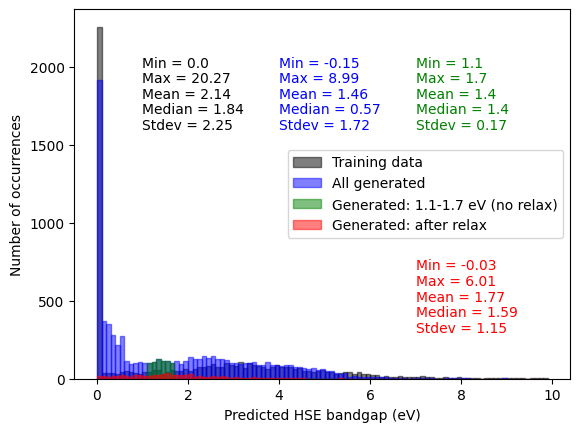

In [ ]:
# Bandgap histograms

bins = np.arange(0, 10, 0.1)
plt.hist(train_data['HSE bandgap (eV)'], bins=bins, color='black', edgecolor='black', alpha=0.5, label='Training data')
plt.hist(preds_df['Predicted bandgap (eV)'], bins=bins, color='blue', edgecolor='blue', alpha=0.5, label='All generated')
plt.hist(df_promising['Predicted bandgap (eV)'], bins=bins, color='green', edgecolor='green', alpha=0.5, label='Generated: 1.1-1.7 eV (no relax)')
plt.hist(preds_df_relaxed['Predicted bandgap (eV)'], bins=bins, color='red', edgecolor='red', alpha=0.5, label='Generated: after relax')
plt.xlabel('Predicted HSE bandgap (eV)')
plt.ylabel('Number of occurrences')

minn = min(train_data['HSE bandgap (eV)'])
maxx = max(train_data['HSE bandgap (eV)'])
mean = np.mean(train_data['HSE bandgap (eV)'])
median = np.median(train_data['HSE bandgap (eV)'])
stdev = np.std(train_data['HSE bandgap (eV)'])

plt.text(1, 2000, 'Min = '+str(round(minn, 2)), color='black')
plt.text(1, 1900, 'Max = '+str(round(maxx, 2)), color='black')
plt.text(1, 1800, 'Mean = '+str(round(mean, 2)), color='black')
plt.text(1, 1700, 'Median = '+str(round(median, 2)), color='black')
plt.text(1, 1600, 'Stdev = '+str(round(stdev, 2)), color='black')

minn = min(preds_df['Predicted bandgap (eV)'])
maxx = max(preds_df['Predicted bandgap (eV)'])
mean = np.mean(preds_df['Predicted bandgap (eV)'])
median = np.median(preds_df['Predicted bandgap (eV)'])
stdev = np.std(preds_df['Predicted bandgap (eV)'])

plt.text(4, 2000, 'Min = '+str(round(minn, 2)), color='blue')
plt.text(4, 1900, 'Max = '+str(round(maxx, 2)), color='blue')
plt.text(4, 1800, 'Mean = '+str(round(mean, 2)), color='blue')
plt.text(4, 1700, 'Median = '+str(round(median, 2)), color='blue')
plt.text(4, 1600, 'Stdev = '+str(round(stdev, 2)), color='blue')

minn = min(df_promising['Predicted bandgap (eV)'])
maxx = max(df_promising['Predicted bandgap (eV)'])
mean = np.mean(df_promising['Predicted bandgap (eV)'])
median = np.median(df_promising['Predicted bandgap (eV)'])
stdev = np.std(df_promising['Predicted bandgap (eV)'])

plt.text(7, 2000, 'Min = '+str(round(minn, 2)), color='green')
plt.text(7, 1900, 'Max = '+str(round(maxx, 2)), color='green')
plt.text(7, 1800, 'Mean = '+str(round(mean, 2)), color='green')
plt.text(7, 1700, 'Median = '+str(round(median, 2)), color='green')
plt.text(7, 1600, 'Stdev = '+str(round(stdev, 2)), color='green')

#'''
minn = min(preds_df_relaxed['Predicted bandgap (eV)'])
maxx = max(preds_df_relaxed['Predicted bandgap (eV)'])
mean = np.mean(preds_df_relaxed['Predicted bandgap (eV)'])
median = np.median(preds_df_relaxed['Predicted bandgap (eV)'])
stdev = np.std(preds_df_relaxed['Predicted bandgap (eV)'])

plt.text(7, 700, 'Min = '+str(round(minn, 2)), color='red')
plt.text(7, 600, 'Max = '+str(round(maxx, 2)), color='red')
plt.text(7, 500, 'Mean = '+str(round(mean, 2)), color='red')
plt.text(7, 400, 'Median = '+str(round(median, 2)), color='red')
plt.text(7, 300, 'Stdev = '+str(round(stdev, 2)), color='red')
#'''

plt.legend(loc='center right')
plt.savefig('Predicted_bandgap_histogram_generated_relaxed_v2.png', dpi=250, bbox_inches='tight')

In [ ]:
preds_df_relaxed

,Structure,Formula,Predicted log10 Bulk Modulus (GPa)
0,"[[4.20482133 5.48150001 8.35046714] Fe, [2.455...",Ta3 Ti1 Fe2 Si2 C4,2.342
1,"[[3.16479956 1.12784318 0.66674639] V, [ 0.930...",Li1 Ti1 V1 Ir3,2.319
2,"[[1.11748185 1.02904263 0.07265477] Pt, [3.021...",Al1 Co1 Pt2,2.325
3,"[[1.40271613 2.98018591 5.62275887] Ti, [0.607...",Ti10 N10,2.347
4,"[[1.89540723 0.67996951 4.08371683] Nb, [ 0.49...",Nb4 Si2,2.286
...,...,...,...
382,"[[1.57790018 0.57250365 4.56847006] Be, [2.414...",Hf1 Ti3 Be2 Re5 W1,2.358
383,"[[2.15631716 1.12543223 5.03056377] Pt, [3.277...",Fe1 Si1 Pt2,2.320
384,"[[2.60821182 0.55060402 3.71613985] Ir, [4.063...",Ti2 Sn1 B1 Ir2 C1,2.283
385,"[[1.67309663 1.40627201 4.76622228] Ir, [-0.11...",P2 Ir2 Pd1,2.341


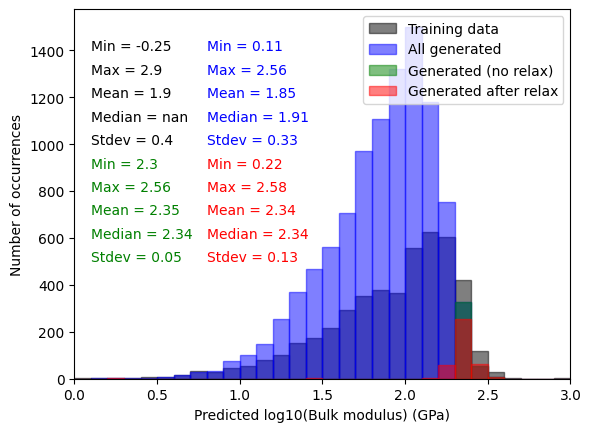

In [ ]:
# Bulk modulus histograms

bins = np.arange(0, 10, 0.1)

x1 = np.log10(train_data['K_Voigt (GPa)'])
x2 = preds_df['Predicted log10 Bulk Modulus (GPa)']

x3 = df_promising['Predicted log10 Bulk Modulus (GPa)']
x4 = preds_df_relaxed['Predicted log10 Bulk Modulus (GPa)']

plt.hist(x1, bins=bins, color='black', edgecolor='black', alpha=0.5, label='Training data')
plt.hist(x2, bins=bins, color='blue', edgecolor='blue', alpha=0.5, label='All generated')
plt.hist(x3, bins=bins, color='green', edgecolor='green', alpha=0.5, label='Generated (no relax)')
plt.hist(x4, bins=bins, color='red', edgecolor='red', alpha=0.5, label='Generated after relax')
plt.xlabel('Predicted log10(Bulk modulus) (GPa)')
plt.ylabel('Number of occurrences')

minn = min(x1)
maxx = max(x1)
mean = np.mean(x1)
median = np.median(x1)
stdev = np.std(x1)

plt.text(0.1, 1400, 'Min = '+str(round(minn, 2)), color='black')
plt.text(0.1, 1300, 'Max = '+str(round(maxx, 2)), color='black')
plt.text(0.1, 1200, 'Mean = '+str(round(mean, 2)), color='black')
plt.text(0.1, 1100, 'Median = '+str(round(median, 2)), color='black')
plt.text(0.1, 1000, 'Stdev = '+str(round(stdev, 2)), color='black')

minn = min(x2)
maxx = max(x2)
mean = np.mean(x2)
median = np.median(x2)
stdev = np.std(x2)

plt.text(0.8, 1400, 'Min = '+str(round(minn, 2)), color='blue')
plt.text(0.8, 1300, 'Max = '+str(round(maxx, 2)), color='blue')
plt.text(0.8, 1200, 'Mean = '+str(round(mean, 2)), color='blue')
plt.text(0.8, 1100, 'Median = '+str(round(median, 2)), color='blue')
plt.text(0.8, 1000, 'Stdev = '+str(round(stdev, 2)), color='blue')

minn = min(x3)
maxx = max(x3)
mean = np.mean(x3)
median = np.median(x3)
stdev = np.std(x3)

plt.text(0.1, 900, 'Min = '+str(round(minn, 2)), color='green')
plt.text(0.1, 800, 'Max = '+str(round(maxx, 2)), color='green')
plt.text(0.1, 700, 'Mean = '+str(round(mean, 2)), color='green')
plt.text(0.1, 600, 'Median = '+str(round(median, 2)), color='green')
plt.text(0.1, 500, 'Stdev = '+str(round(stdev, 2)), color='green')

#'''
minn = min(x4)
maxx = max(x4)
mean = np.mean(x4)
median = np.median(x4)
stdev = np.std(x4)

plt.text(0.8, 900, 'Min = '+str(round(minn, 2)), color='red')
plt.text(0.8, 800, 'Max = '+str(round(maxx, 2)), color='red')
plt.text(0.8, 700, 'Mean = '+str(round(mean, 2)), color='red')
plt.text(0.8, 600, 'Median = '+str(round(median, 2)), color='red')
plt.text(0.8, 500, 'Stdev = '+str(round(stdev, 2)), color='red')
#'''

plt.xlim(0, 3)

plt.legend(loc='upper right')
plt.savefig('Predicted_bulkmod_histogram_generated_v2.png', dpi=250, bbox_inches='tight')

In [ ]:
preds_df_relaxed

,Structure,Formula,Predicted log10 dielectric constant
0,"[[0.92196635 1.77288451 1.63194585] La, [3.553...",La1 O2,1.292
1,"[[3.63591188 4.56481157 0.52082297] Ag, [0.736...",Ag2 Bi2 Se1 Br1 Cl2 O2,1.931
2,"[[1.64849516 3.17102404 1.06119852] Pb, [ 4.20...",Li1 Pb3 Se4,2.003
3,"[[7.78076607 4.17939903 3.35186264] Fe, [6.321...",Fe1 N1 O3,0.877
4,"[[3.24032768 2.96605179 0.50750197] Te, [1.386...",Y1 Te1,2.962
...,...,...,...
131,"[[0.89598795 3.10989623 0.14040965] Na, [0.167...",Na5 Ta1 Nb1 Se7,1.444
132,"[[ 0.93341628 3.7830832 -0.12214777] Ta, [0....",Ta2 Fe3 Si2,1.916
133,"[[-0.02807999 2.05797222 6.4441614 ] Y, [2.8...",Sr1 Y2 Sn1 Te4 Pb6 Se6,1.763
134,"[[1.26106424 2.404888 8.79182579] Nb, [3.425...",Na4 Nb2 O10,1.354


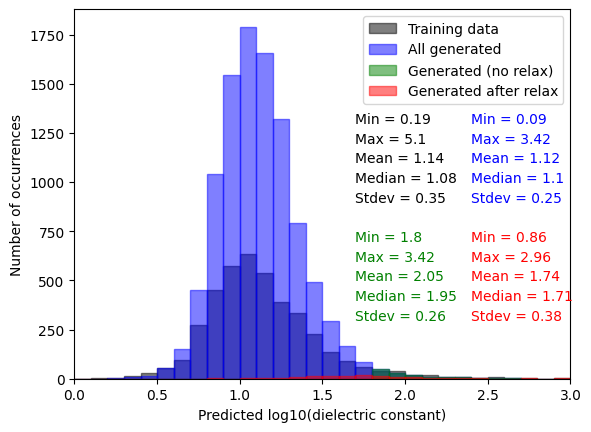

In [ ]:
# Dielectric constant histograms

bins = np.arange(0, 10, 0.1)

x1 = train_data['log(poly_total)']
x2 = preds_df['Predicted log10 dielectric constant']

x3 = df_promising['Predicted log10 dielectric constant']
x4 = preds_df_relaxed['Predicted log10 dielectric constant']

plt.hist(x1, bins=bins, color='black', edgecolor='black', alpha=0.5, label='Training data')
plt.hist(x2, bins=bins, color='blue', edgecolor='blue', alpha=0.5, label='All generated')
plt.hist(x3, bins=bins, color='green', edgecolor='green', alpha=0.5, label='Generated (no relax)')
plt.hist(x4, bins=bins, color='red', edgecolor='red', alpha=0.5, label='Generated after relax')
plt.xlabel('Predicted log10(dielectric constant)')
plt.ylabel('Number of occurrences')

minn = min(x1)
maxx = max(x1)
mean = np.mean(x1)
median = np.median(x1)
stdev = np.std(x1)

plt.text(1.7, 1300, 'Min = '+str(round(minn, 2)), color='black')
plt.text(1.7, 1200, 'Max = '+str(round(maxx, 2)), color='black')
plt.text(1.7, 1100, 'Mean = '+str(round(mean, 2)), color='black')
plt.text(1.7, 1000, 'Median = '+str(round(median, 2)), color='black')
plt.text(1.7, 900, 'Stdev = '+str(round(stdev, 2)), color='black')

minn = min(x2)
maxx = max(x2)
mean = np.mean(x2)
median = np.median(x2)
stdev = np.std(x2)

plt.text(2.4, 1300, 'Min = '+str(round(minn, 2)), color='blue')
plt.text(2.4, 1200, 'Max = '+str(round(maxx, 2)), color='blue')
plt.text(2.4, 1100, 'Mean = '+str(round(mean, 2)), color='blue')
plt.text(2.4, 1000, 'Median = '+str(round(median, 2)), color='blue')
plt.text(2.4, 900, 'Stdev = '+str(round(stdev, 2)), color='blue')

minn = min(x3)
maxx = max(x3)
mean = np.mean(x3)
median = np.median(x3)
stdev = np.std(x3)

plt.text(1.7, 700, 'Min = '+str(round(minn, 2)), color='green')
plt.text(1.7, 600, 'Max = '+str(round(maxx, 2)), color='green')
plt.text(1.7, 500, 'Mean = '+str(round(mean, 2)), color='green')
plt.text(1.7, 400, 'Median = '+str(round(median, 2)), color='green')
plt.text(1.7, 300, 'Stdev = '+str(round(stdev, 2)), color='green')

#'''
minn = min(x4)
maxx = max(x4)
mean = np.mean(x4)
median = np.median(x4)
stdev = np.std(x4)

plt.text(2.4, 700, 'Min = '+str(round(minn, 2)), color='red')
plt.text(2.4, 600, 'Max = '+str(round(maxx, 2)), color='red')
plt.text(2.4, 500, 'Mean = '+str(round(mean, 2)), color='red')
plt.text(2.4, 400, 'Median = '+str(round(median, 2)), color='red')
plt.text(2.4, 300, 'Stdev = '+str(round(stdev, 2)), color='red')
#'''

plt.xlim(0, 3)

plt.legend(loc='upper right')
plt.savefig('Predicted_dielectric_histogram_generated_v2.png', dpi=250, bbox_inches='tight')

In [ ]:
# Look for M3GNET relaxed materials that are in the range of 1.1-1.7 eV

df_promising_relaxed = preds_df_relaxed[preds_df_relaxed['Predicted bandgap (eV)'] <= 1.7]
df_promising_relaxed = df_promising_relaxed[df_promising_relaxed['Predicted bandgap (eV)'] >= 1.1]
df_promising_relaxed.shape

(160, 4)

In [ ]:
# Look for M3GNET relaxed materials that are bulk modulus (log scale) > 2.3

df_promising_relaxed = preds_df_relaxed[preds_df_relaxed['Predicted log10 Bulk Modulus (GPa)'] >= 2.3]
df_promising_relaxed.shape

(324, 3)

In [ ]:
# Look for M3GNET relaxed materials that are dielectric (log scale) > 1.8

df_promising_relaxed = preds_df_relaxed[preds_df_relaxed['Predicted log10 dielectric constant'] >= 1.8]
df_promising_relaxed.shape

(52, 3)

In [ ]:
df_promising_relaxed.to_csv('promising_materials_generated_relaxed_subset.csv', index=False)

with open('promising_materials_generated_relaxed_subset.pkl', 'wb') as f:
    dill.dump(df_promising_relaxed, f)

In [ ]:
df_promising.sort_values('Formula')

,Structure,Formula,Predicted log10 dielectric constant
8331,"[[4.99069093 1.31937029 1.84338182] Pb, [2.375...",Ag1 As1 Pb2 I3,1.952
7405,"[[1.52086798 5.17358056 9.17312823] S, [3.7241...",Ag1 Bi3 S6,2.010
4210,"[[2.84767867 3.33154763 1.97214246] Ag, [0.855...",Ag1 Sb1 S2,2.422
4215,[[3.06718240e+00 6.22325408e-01 5.39478807e-04...,Ag2 Bi1 I1 O2,2.400
592,"[[2.65908486 1.69942034 3.44327776] Bi, [ 0.85...",Ag2 Bi1 S3,2.353
...,...,...,...
7781,"[[1.57022656 0.07819827 3.15608373] Y, [3.0715...",Y2 Te2,2.360
5348,"[[1.69270072 1.76263544 4.06319613] Hf, [4.009...",Yb1 Hf2 Si1,2.454
8305,"[[2.18275641 3.87259365 5.08180583] Zn, [0.851...",Zn3 Bi2 Te5,1.907
4146,"[[3.11506005 3.22944354 4.69689769] Sn, [1.423...",Zr1 Sn1,1.867


In [ ]:
preds_df_relaxed.sort_values('Formula')

,Structure,Formula,Predicted log10 dielectric constant
117,"[[5.29422324 0.98500685 1.28252579] Pb, [2.272...",Ag1 As1 Pb2 I3,1.704
101,"[[1.15237541 6.11972466 8.99549197] S, [3.7517...",Ag1 Bi3 S6,2.277
65,"[[2.76024151 3.19263677 1.91981409] Ag, [0.849...",Ag1 Sb1 S2,2.431
66,"[[ 2.88368778 0.36032864 -0.26911611] Bi, [-0...",Ag2 Bi1 I1 O2,1.665
11,"[[2.15213306 1.31907081 4.22866011] Bi, [ 0.35...",Ag2 Bi1 S3,2.802
...,...,...,...
108,"[[ 1.06694029 -0.50733698 4.25860009] Y, [2.2...",Y2 Te2,1.544
76,"[[1.85127888 2.07583746 4.03913431] Hf, [3.993...",Yb1 Hf2 Si1,2.781
116,"[[8.00947485 1.7479851 7.09008025] Zn, [7.784...",Zn3 Bi2 Te5,1.788
63,"[[2.59416003 2.74314897 2.99887192] Sn, [0.585...",Zr1 Sn1,2.257


In [ ]:
df_promising_relaxed.sort_values('Formula')

,Structure,Formula,Predicted log10 dielectric constant
101,"[[1.15237541 6.11972466 8.99549197] S, [3.7517...",Ag1 Bi3 S6,2.277
65,"[[2.76024151 3.19263677 1.91981409] Ag, [0.849...",Ag1 Sb1 S2,2.431
11,"[[2.15213306 1.31907081 4.22866011] Bi, [ 0.35...",Ag2 Bi1 S3,2.802
1,"[[3.63591188 4.56481157 0.52082297] Ag, [0.736...",Ag2 Bi2 Se1 Br1 Cl2 O2,1.931
46,"[[1.3523105 2.4954012 6.7214998] Pb, [3.144590...",Ag3 Bi2 Pb1 Se6,2.462
35,"[[2.67101711 1.73240062 6.53172491] Ag, [5.794...",Ba1 Ag1 Te1,1.813
111,"[[2.86019233 0.72164528 6.32381661] Ba, [0.511...",Ba2 Bi2 O4,1.840
9,"[[3.77048319 0.62006114 8.2883788 ] Ta, [2.411...",Ba2 Ta4 O10 F2,1.912
26,"[[-0.17175058 4.46608885 5.84618003] In, [1....",Ca1 In1 Sb1 As5 Pb2,2.097
95,"[[4.27265002 3.65208663 4.50404475] Sb, [1.392...",Ca2 Cd1 Sb1 S4,2.922


In [ ]:
# Look at the materials shared between the pre-relaxed and relaxed promising list, and examine their bandgap differences
gap_promising = list()
gap_promising_relaxed = list()
comps_unique = list()
for i in df_promising['Formula']:
    for j in df_promising_relaxed['Formula']:
        if i == j:
            if i not in comps_unique:
                comps_unique.append(i)
                print('found', i, j)
                gap_promising.append(df_promising[df_promising['Formula']==i]['Predicted bandgap (eV)'].values[0])
                gap_promising_relaxed.append(df_promising_relaxed[df_promising_relaxed['Formula']==i]['Predicted bandgap (eV)'].values[0])


found Na2 Mn5 Cr1 O10 Na2 Mn5 Cr1 O10
found Na3 Sr1 Cu2 Br1 O7 Na3 Sr1 Cu2 Br1 O7
found Hf1 Ti2 Ag1 O2 F10 Hf1 Ti2 Ag1 O2 F10
found Rb1 Cr2 Bi1 Pd2 O8 Rb1 Cr2 Bi1 Pd2 O8
found Cs1 Ba2 Sb1 As1 H3 I6 N1 O1 Cs1 Ba2 Sb1 As1 H3 I6 N1 O1
found Cs1 Hg3 C1 I1 Br1 O6 Cs1 Hg3 C1 I1 Br1 O6
found Mg1 Zn1 Cu1 P1 O6 Mg1 Zn1 Cu1 P1 O6
found Rb1 Ti3 Cu1 O7 Rb1 Ti3 Cu1 O7
found Sn1 Au1 Br1 Cl1 Sn1 Au1 Br1 Cl1
found K1 Na1 Cd1 Ag1 Te3 I1 K1 Na1 Cd1 Ag1 Te3 I1
found Ti1 V1 Cr2 Fe1 O10 Ti1 V1 Cr2 Fe1 O10
found Rb2 K1 Sr1 Ca2 Cd1 Ga2 Ag1 Sn1 Te2 I3 Rb2 K1 Sr1 Ca2 Cd1 Ga2 Ag1 Sn1 Te2 I3
found Na1 Cr1 O3 Na1 Cr1 O3
found H5 C1 I3 N1 H5 C1 I3 N1
found Cs2 K1 Na3 Co1 As1 O8 Cs2 K1 Na3 Co1 As1 O8
found Ge2 H6 C1 I4 N1 Ge2 H6 C1 I4 N1
found Sc1 Mn1 Al1 Tl1 As2 N3 O7 Sc1 Mn1 Al1 Tl1 As2 N3 O7
found Ge1 H6 I4 Br1 N2 Ge1 H6 I4 Br1 N2
found K2 Ba1 Li1 Tl2 Cr1 Cd1 Si1 O9 K2 Ba1 Li1 Tl2 Cr1 Cd1 Si1 O9
found Sn1 H8 C1 I6 N2 Sn1 H8 C1 I6 N2
found H4 I3 N1 H4 I3 N1
found Ti4 I3 Br1 O6 Ti4 I3 Br1 O6
found Ba1 Lu1 Tl1 Ag1 

In [ ]:
print(df_promising.shape, df_promising_relaxed.shape, len(gap_promising))

(670, 4) (160, 4) 153


Text(0, 0.5, 'MEGnet HSE bandgap (M3GNet-relaxed) (eV)')

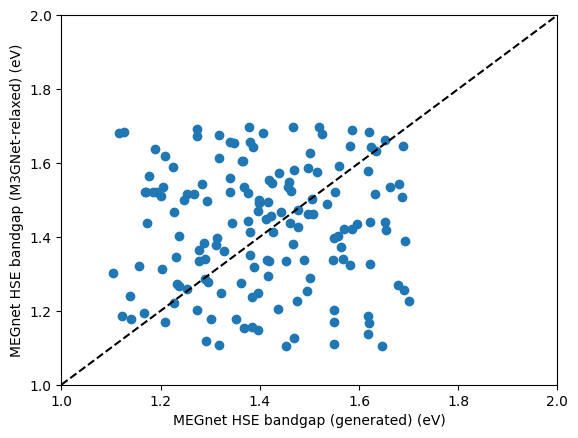

In [ ]:
plt.clf()
plt.scatter(gap_promising, gap_promising_relaxed)
plt.xlim(1, 2)
plt.ylim(1, 2)
plt.plot([1, 2], [1, 2], 'k--')
plt.xlabel('MEGnet HSE bandgap (generated) (eV)')
plt.ylabel('MEGnet HSE bandgap (M3GNet-relaxed) (eV)')

In [ ]:
# Look at the materials shared between the pre-relaxed and relaxed promising list, and examine their bandgap differences
gap_generated = list()
gap_generated_relaxed = list()
comps_unique = list()
for i in df_promising['Formula']: #preds_df['Formula']:
    for j in preds_df_relaxed['Formula']:
        if i == j:
            if i not in comps_unique:
                comps_unique.append(i)
                print('found', i, j)
                gap_generated.append(df_promising[df_promising['Formula']==i]['Predicted bandgap (eV)'].values[0])
                gap_generated_relaxed.append(preds_df_relaxed[preds_df_relaxed['Formula']==i]['Predicted bandgap (eV)'].values[0])


found Cs1 La1 As3 Ru1 N4 Cs1 La1 As3 Ru1 N4
found Ba1 Cu1 Te1 I1 Ba1 Cu1 Te1 I1
found Cr3 Cd2 N1 Cl1 O5 Cr3 Cd2 N1 Cl1 O5
found Ge1 H5 I3 N2 Ge1 H5 I3 N2
found Na2 Mn5 Cr1 O10 Na2 Mn5 Cr1 O10
found Ge1 H4 I2 N1 Cl1 Ge1 H4 I2 N1 Cl1
found Na1 Li1 Ti1 Cu2 P1 O8 Na1 Li1 Ti1 Cu2 P1 O8
found Na2 Fe3 P1 O10 Na2 Fe3 P1 O10
found Na3 Sr1 Cu2 Br1 O7 Na3 Sr1 Cu2 Br1 O7
found Hf1 Ti2 Ag1 O2 F10 Hf1 Ti2 Ag1 O2 F10
found Cs1 Rb1 Hf1 Zr1 Mn1 Cd1 Sn1 P1 O10 Cs1 Rb1 Hf1 Zr1 Mn1 Cd1 Sn1 P1 O10
found Zn1 B1 As1 N1 O4 F1 Zn1 B1 As1 N1 O4 F1
found Rb1 Ti1 O4 Rb1 Ti1 O4
found Ru1 Se2 Ru1 Se2
found H8 Pb2 C1 I5 N2 H8 Pb2 C1 I5 N2
found Rb1 Cr2 Bi1 Pd2 O8 Rb1 Cr2 Bi1 Pd2 O8
found Cs1 Ba2 Sb1 As1 H3 I6 N1 O1 Cs1 Ba2 Sb1 As1 H3 I6 N1 O1
found Ba3 La1 Ti1 Cd1 Te1 O6 Ba3 La1 Ti1 Cd1 Te1 O6
found Li1 La1 Ag1 Se1 Li1 La1 Ag1 Se1
found Ti1 Cu2 O7 Ti1 Cu2 O7
found Tl1 Ge2 H5 I5 N2 Tl1 Ge2 H5 I5 N2
found Li3 As1 S1 O1 Li3 As1 S1 O1
found H4 Br1 N1 Cl2 H4 Br1 N1 Cl2
found Cs1 Hg3 C1 I1 Br1 O6 Cs1 Hg3 C1 I1 Br1 O6
foun

In [ ]:
print(preds_df.shape, preds_df_relaxed.shape, len(gap_generated), len(gap_generated_relaxed))

(9939, 4) (669, 4) 646 646


1.4013298 0.16656548


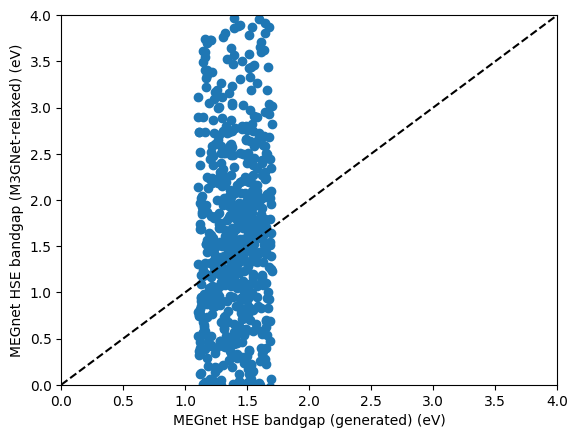

In [ ]:
plt.clf()
plt.scatter(gap_generated, gap_generated_relaxed)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.plot([0, 4], [0, 4], 'k--')
plt.xlabel('MEGnet HSE bandgap (generated) (eV)')
plt.ylabel('MEGnet HSE bandgap (M3GNet-relaxed) (eV)')

print(np.mean(gap_generated), np.std(gap_generated))

In [ ]:
df_gap_compare = pd.DataFrame({'comp': comps_unique,
                               'gap': gap_generated,
                               'gap relax': gap_generated_relaxed,
                              'gap diff': np.array(gap_generated_relaxed)-np.array(gap_generated)})

df_gap_compare.sort_values('gap diff')

,comp,gap,gap relax,gap diff
228,Fe1 O2,1.687,-0.029,-1.716
197,Ga1 Si3 O10,1.689,0.060,-1.629
581,Rb1 K1 Cd1 Au1 O5,1.606,-0.001,-1.607
371,Ti1 S1,1.595,0.022,-1.573
609,Nb1 S1 F1,1.565,0.010,-1.555
...,...,...,...,...
458,Ca2 Hf1 Ta2 N1 O8,1.426,5.330,3.904
82,H1 C5 O12,1.302,5.320,4.018
545,Rb1 P1 O4,1.552,5.588,4.036
604,Na1 Li1 F3,1.281,6.015,4.734


In [ ]:
gap_diffs = np.array(gap_generated)-np.array(gap_generated_relaxed)
sorted(gap_diffs)

[-4.8289995,
 -4.7339997,
 -4.036,
 -4.018,
 -3.9039998,
 -3.513,
 -3.462,
 -3.4379997,
 -3.398,
 -3.383,
 -3.3050003,
 -3.264,
 -3.2589998,
 -3.2559998,
 -3.2089999,
 -3.169,
 -3.0870001,
 -3.085,
 -3.0770001,
 -3.072,
 -3.0679998,
 -3.0570002,
 -3.047,
 -2.933,
 -2.8930001,
 -2.868,
 -2.864,
 -2.7459998,
 -2.732,
 -2.719,
 -2.635,
 -2.632,
 -2.629,
 -2.586,
 -2.578,
 -2.549,
 -2.526,
 -2.521,
 -2.515,
 -2.4900002,
 -2.474,
 -2.463,
 -2.461,
 -2.46,
 -2.449,
 -2.439,
 -2.414,
 -2.3909998,
 -2.37,
 -2.348,
 -2.334,
 -2.2729998,
 -2.271,
 -2.27,
 -2.25,
 -2.231,
 -2.1890001,
 -2.182,
 -2.176,
 -2.174,
 -2.168,
 -2.1629999,
 -2.151,
 -2.099,
 -2.091,
 -2.0629997,
 -2.0609999,
 -2.059,
 -2.0489998,
 -2.005,
 -1.993,
 -1.9890001,
 -1.9679999,
 -1.9390001,
 -1.9250001,
 -1.916,
 -1.915,
 -1.899,
 -1.866,
 -1.86,
 -1.8599999,
 -1.855,
 -1.815,
 -1.8100001,
 -1.804,
 -1.8000001,
 -1.7710001,
 -1.752,
 -1.737,
 -1.729,
 -1.6850001,
 -1.6710001,
 -1.6560001,
 -1.653,
 -1.641,
 -1.6279999,
 -1.6

1.460293 1.7166502


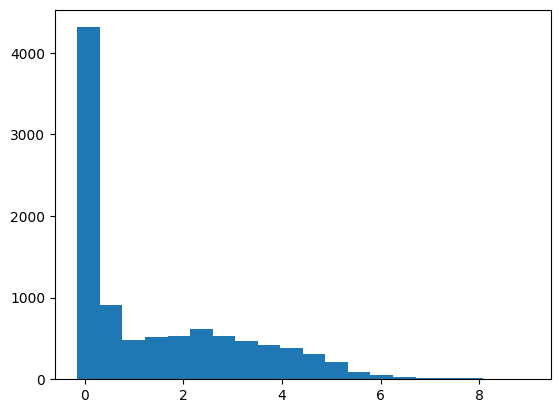

In [ ]:
gaps = preds_df['Predicted bandgap (eV)']
plt.hist(gaps, bins=20)

print(np.mean(gaps), np.std(gaps))

In [ ]:
!pip install p-tqdm

In [ ]:
!pip install hydra-core

In [ ]:
!pip install smact

In [ ]:
!pip install torch_scatter

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install m3gnet

In [ ]:
!pip install timeout-decorator